# Affine transforms
This notebook demonstrates how to apply affine transforms to 3D images.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from skimage.io import imshow, imread

import pyclesperanto as cle

cle.select_device()

(OpenCL) NVIDIA GeForce RTX 4090 (OpenCL 3.0 CUDA)
	Vendor:                      NVIDIA Corporation
	Driver Version:              535.216.01
	Device Type:                 GPU
	Compute Units:               128
	Global Memory Size:          24217 MB
	Maximum Object Size:         6054 MB
	Max Clock Frequency:         2625 MHz
	Image Support:               Yes

(120, 160, 160)


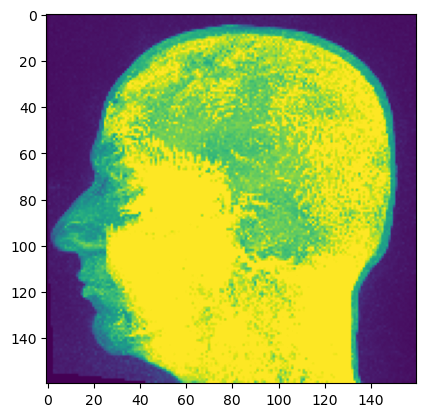

In [2]:
# Laod example data
input_image = imread("../data/Haase_MRT_tfl3d1.tif")
print(input_image.shape)
plt.imshow(input_image.max(axis=0))

## Rotation
For rotating an image, you need to provide angles corresponding to axes.

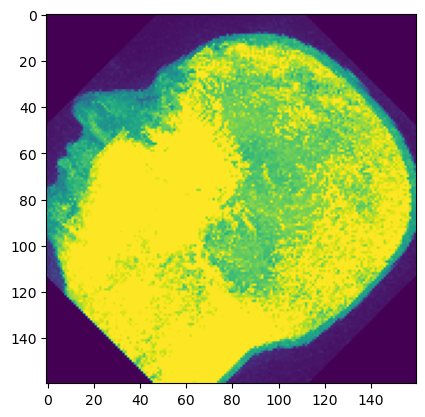

In [3]:
rotated = cle.rotate(input_image, angle_z=45)
plt.imshow(cle.pull(rotated).max(axis=0))

Images are rotated around their center by default. You can change this by providing an additional parameter. The image will then be rotated around the origin.

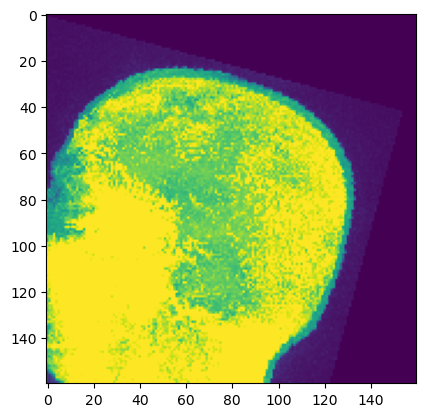

In [4]:
rotated = cle.rotate(input_image, angle_z=15, centered=False)
plt.imshow(cle.pull(rotated).max(axis=0))

## Translation
Images can be translate by providing translation distances along axes:

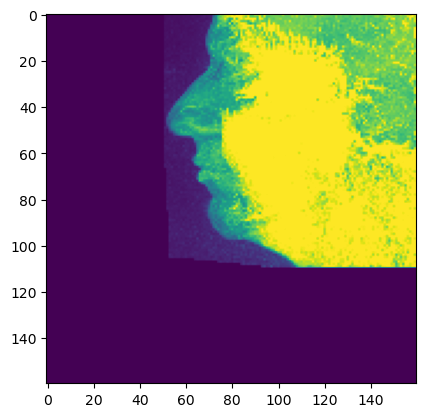

In [5]:
translated = cle.translate(input_image, translate_x=50, translate_y=-50)
plt.imshow(cle.pull(translated).max(axis=0))

## Scaling
You can scale the image by providing scaling factors.

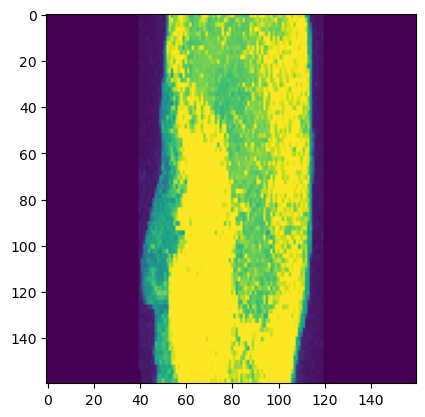

In [6]:
scaled = cle.scale(input_image, factor_x=0.5, factor_y=2)
plt.imshow(cle.pull(scaled).max(axis=0))

## Auto-size
Especially for scaling, the `auto_size` parameter may be helpful:

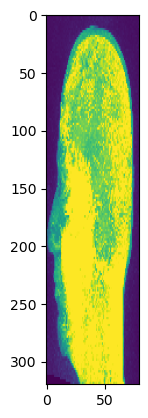

In [7]:
scaled = cle.scale(input_image, factor_x=0.5, factor_y=2, resize=True)
plt.imshow(cle.pull(scaled).max(axis=0))

## Rigid transform
Rigid transforms allow to do translations and rotations in one shot

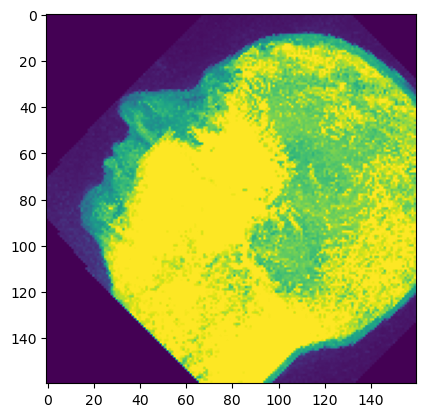

In [8]:
rigid_transformed = cle.rigid_transform(input_image, translate_x=20, angle_z=45)
plt.imshow(cle.pull(rigid_transformed).max(axis=0))

## Affine transforms
To do translation, rotation and scaling in one shot, use affine transforms. [Shearing will be implemented in a future release](https://github.com/clEsperanto/pyclesperanto_prototype/issues/90).

To setup an affine transform, you can do this using a 4x4 transform matrix:

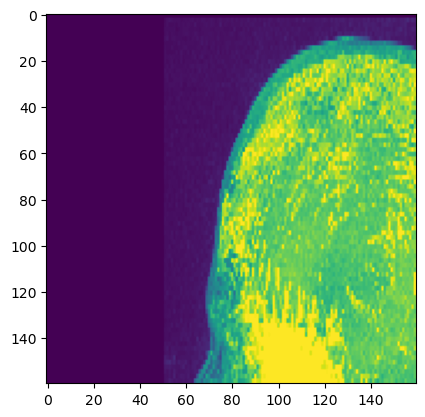

In [9]:
transform_matrix = np.asarray([
    [1, 0, 0, 50],
    [0, 2, 0, 0],
    [0, 0, 0.5, 0],
    [0, 0, 0, 1]
])
transformed_image = cle.affine_transform(input_image, transform_matrix=transform_matrix)
plt.imshow(cle.pull(transformed_image).max(axis=0))

# Interoperability with scikit-image
Scikit-image only supports 2D transforms and thus, we pick a slice to transform it.

We can use the `transforms` package of scikit-image to define an affine transform and apply it to the image.

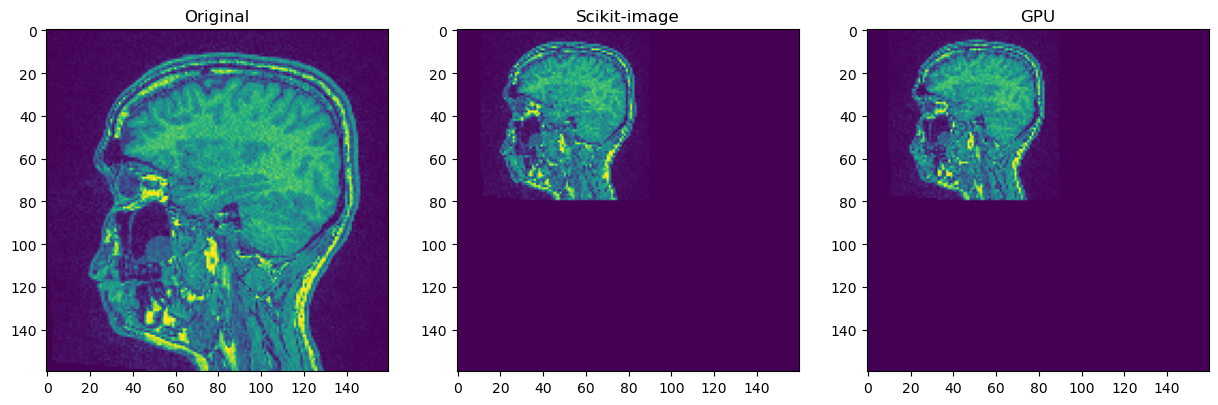

In [10]:
# from skimage.io import imshow
from skimage import transform as tf

transform = tf.AffineTransform(scale=0.5, translation=[10,0])

image = cle.pull(input_image)[80]
transformed_image = tf.warp(image, transform.inverse)
gpu_transformed_image = cle.affine_transform(image, transform_matrix=transform.params)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(image)
ax[0].set_title("Original")
ax[1].imshow(transformed_image)
ax[1].set_title("Scikit-image")
ax[2].imshow(cle.push(gpu_transformed_image))
ax[2].set_title("GPU")
plt.show()

# imshow(image)

# Linear interpolation versus nearest neighbor interpolation

pyclesperanto transformation operation comes with two different interpolation option:
- nearest neighbor interpolation, which is the default one
- linear interpolation, which rely on hardware acceleration (not available on all devices)

> The linear interpolation adapts itself on the dimensionality of the input, if 2D it is a bilinear interpolation, a trilienear for a 3D input.

Let's crop the nose and transform it using different interpolation modes to observe the differences

shape (25, 25, 25)


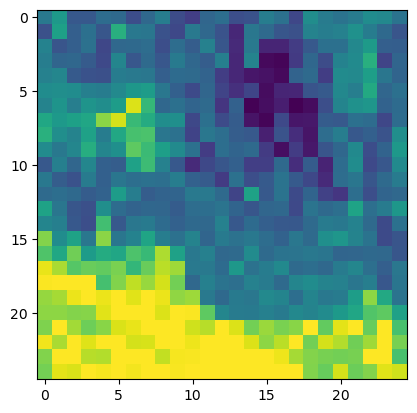

In [11]:
crop = cle.crop(input_image, start_x=45, start_y=125, start_z=50, width=25, height=25, depth=25)
plt.imshow(cle.pull(crop).max(axis=0))
print("shape", crop.shape)

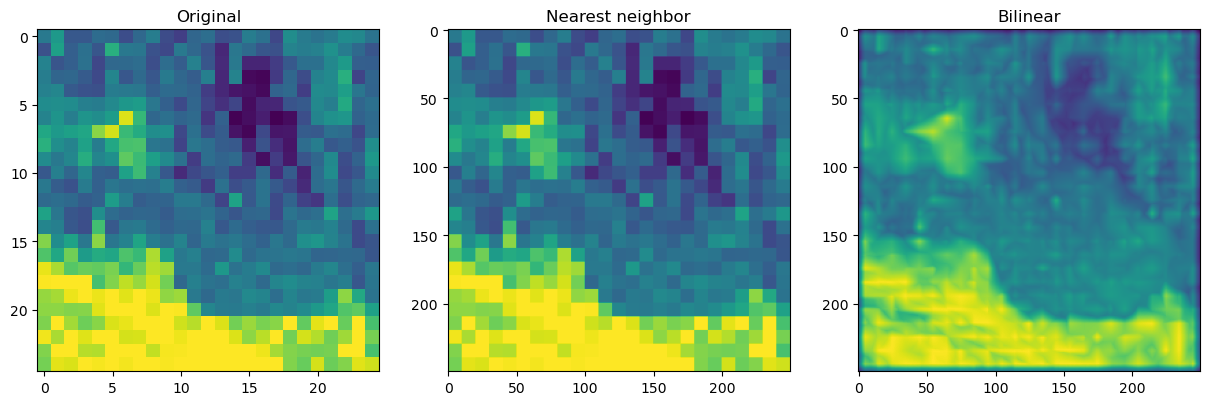

In [13]:
# create a larger image
rescaled_n = cle.create(tuple(dim * 10 for dim in crop.shape))
rescaled_y = cle.create(tuple(dim * 10 for dim in crop.shape))

# fill it with a scaled version of the image; 
cle.scale(crop, rescaled_n, factor_x=10, factor_y=10, factor_z=10, interpolate=False, centered=False)
cle.scale(crop, rescaled_y, factor_x=10, factor_y=10, factor_z=10, interpolate=True, centered=False)

fig, axs = plt.subplots(1, 3, figsize=(15, 10))
axs[0].imshow(cle.pull(crop).max(axis=0))
axs[0].set_title("Original")
axs[1].imshow(cle.pull(rescaled_n).max(axis=0))
axs[1].set_title("Nearest neighbor")
axs[2].imshow(cle.pull(rescaled_y).max(axis=0))
axs[2].set_title("Bilinear")
plt.show()